In [160]:
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True


config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

In [65]:
def plot_projected_dist(x: np.ndarray, y: np.ndarray,
                        dx: np.ndarray, dy: np.ndarray,
                        bins: np.ndarray, density: bool = False,
                        fmt: str = ".", fig: Union[plt.figure, None] = None):
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
        fig.set_size_inches((8, 3.5))
        axs[0].set_xlabel("Tiempo [ms]")
        axs[0].set_ylabel("Tensión [mV]")
    else:
        axs = fig.axes
    
    axs[0].errorbar(x=x, xerr=dx,
                    y=y, yerr=dy,
                    fmt=fmt, ms=6,
                    ecolor="k", capsize=2,
                    alpha=0.5, zorder=10)
    axs[1].hist(x=y, bins=bins, orientation="horizontal", density=density,
                histtype="step", lw=1.5, alpha=0.7, zorder=10)
    
    return fig, axs


def plot_measurements(tiempo: np.ndarray,
                      channel: np.ndarray,
                      min_val: float,
                      max_val: float,
                      med_index: int = 0,
                      n_datos: int = 2000,
                      fig: Union[plt.figure, None] = None,
                      density: bool = False,
                      ) -> tuple[plt.figure, list[plt.axes]]:
    """"""
    t = tiempo[med_index*n_datos:(med_index + 1)*n_datos]
    ch = channel[med_index*n_datos:(med_index + 1)*n_datos]
    
    temp_res = 1/250e3  # s
    volt_res = 1.05*(max_val - min_val)/(2**16)  # V
    
    x = (t - t[0])*1e3  # ms
    dx = temp_res*1e3/2  # ms
    y = ch*1e3  # mV
    dy = volt_res*1e3/2  # mV
    
    bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # mV
    bins = bin_range[(y.max() + 2 >= bin_range) & (y.min() - 2 <= bin_range)]
    if n_datos < 200:
        fig, axs = plot_projected_dist(x, y, dx, dy, bins, density, ".-", fig)
    else:
        fig, axs = plot_projected_dist(x, y, dx, dy, bins, density, ".", fig)
    
    return fig, axs


def get_peaks(tiempo, channel, window_size):
    t = np.reshape(tiempo, (-1, window_size))
    ch = np.reshape(channel, (-1, window_size))
    min_ids = ch.argmin(axis=1, keepdims=True)
    t_min = np.take_along_axis(t, min_ids, axis=1).flatten()
    ch_min = np.take_along_axis(ch, min_ids, axis=1).flatten()
    max_ids = ch.argmax(axis=1, keepdims=True)
    t_max = np.take_along_axis(t, max_ids, axis=1).flatten()
    ch_max = np.take_along_axis(ch, max_ids, axis=1).flatten()
    time = np.concatenate([t_min, t_max])
    chan = np.concatenate([ch_min, ch_max])
    # order = np.argsort(time)
    return time, chan


def plot_custom_peaks(tiempo: np.ndarray,
                      channel: np.ndarray,
                      min_val: float,
                      max_val: float,
                      med_index: int = 0,
                      n_datos: int = 2000,
                      fig: Union[plt.figure, None] = None,
                      density: bool = False,
                      window_size: int = 10
                      ) -> tuple[plt.figure, list[plt.axes]]:
    """"""
    t = tiempo[med_index*n_datos:(med_index + 1)*n_datos]
    ch = channel[med_index*n_datos:(med_index + 1)*n_datos]
    t_p, ch_p = get_peaks(t, ch, window_size)
    
    temp_res = 1/250e3  # s
    volt_res = 1.05*(max_val - min_val)/(2**16)  # V
    
    x = (t_p - t[0])*1e3  # ms
    dx = temp_res*1e3/2  # ms
    y = ch_p*1e3  # mV
    dy = volt_res*1e3/2  # mV
    
    bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # mV
    bins = bin_range[(y.max() + 2 >= bin_range) & (y.min() - 2 <= bin_range)]
    fig, axs = plot_projected_dist(x, y, dx, dy, bins, density, "v", fig)
    
    return fig, axs

## Una Señal DAQ

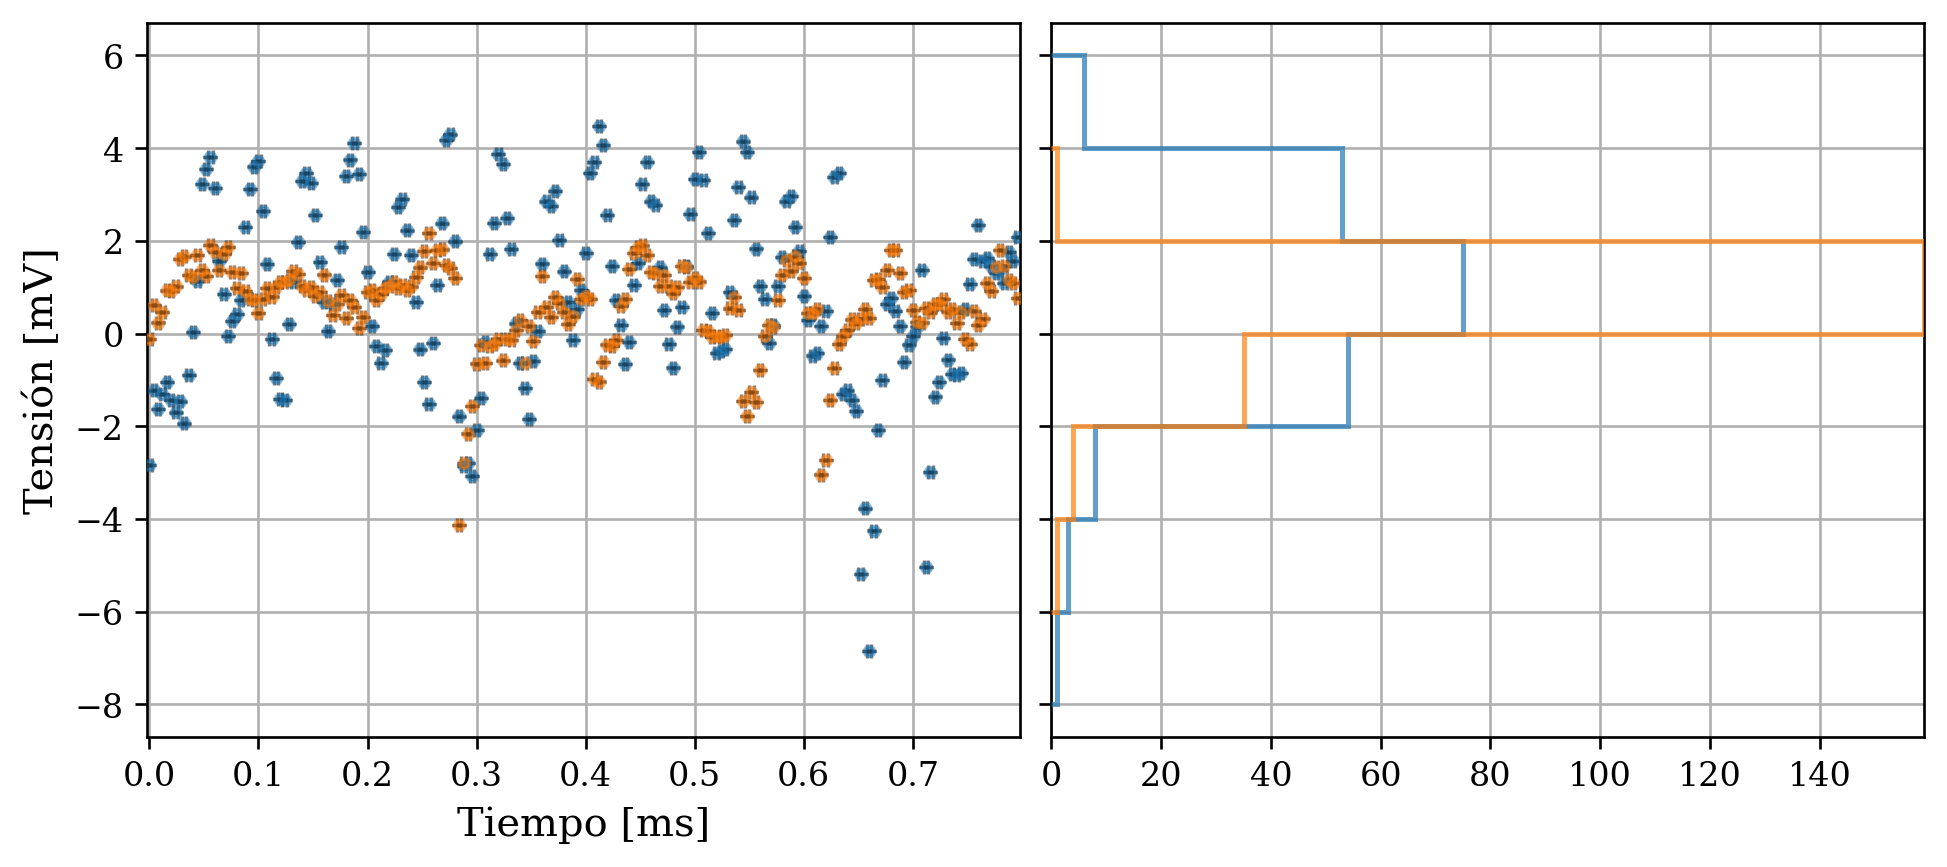

In [66]:
# Leer una tanda guardada:
config = "c"  # Estado del instrumental al medir
tension = 1050  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo, channel = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                           + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V

# Ploteando de a cachos
fig, axs = plot_measurements(tiempo, channel, min_val, max_val, med_index=0, n_datos=200)
plot_measurements(tiempo, channel, min_val, max_val, med_index=6, n_datos=200, fig=fig)
plt.show()

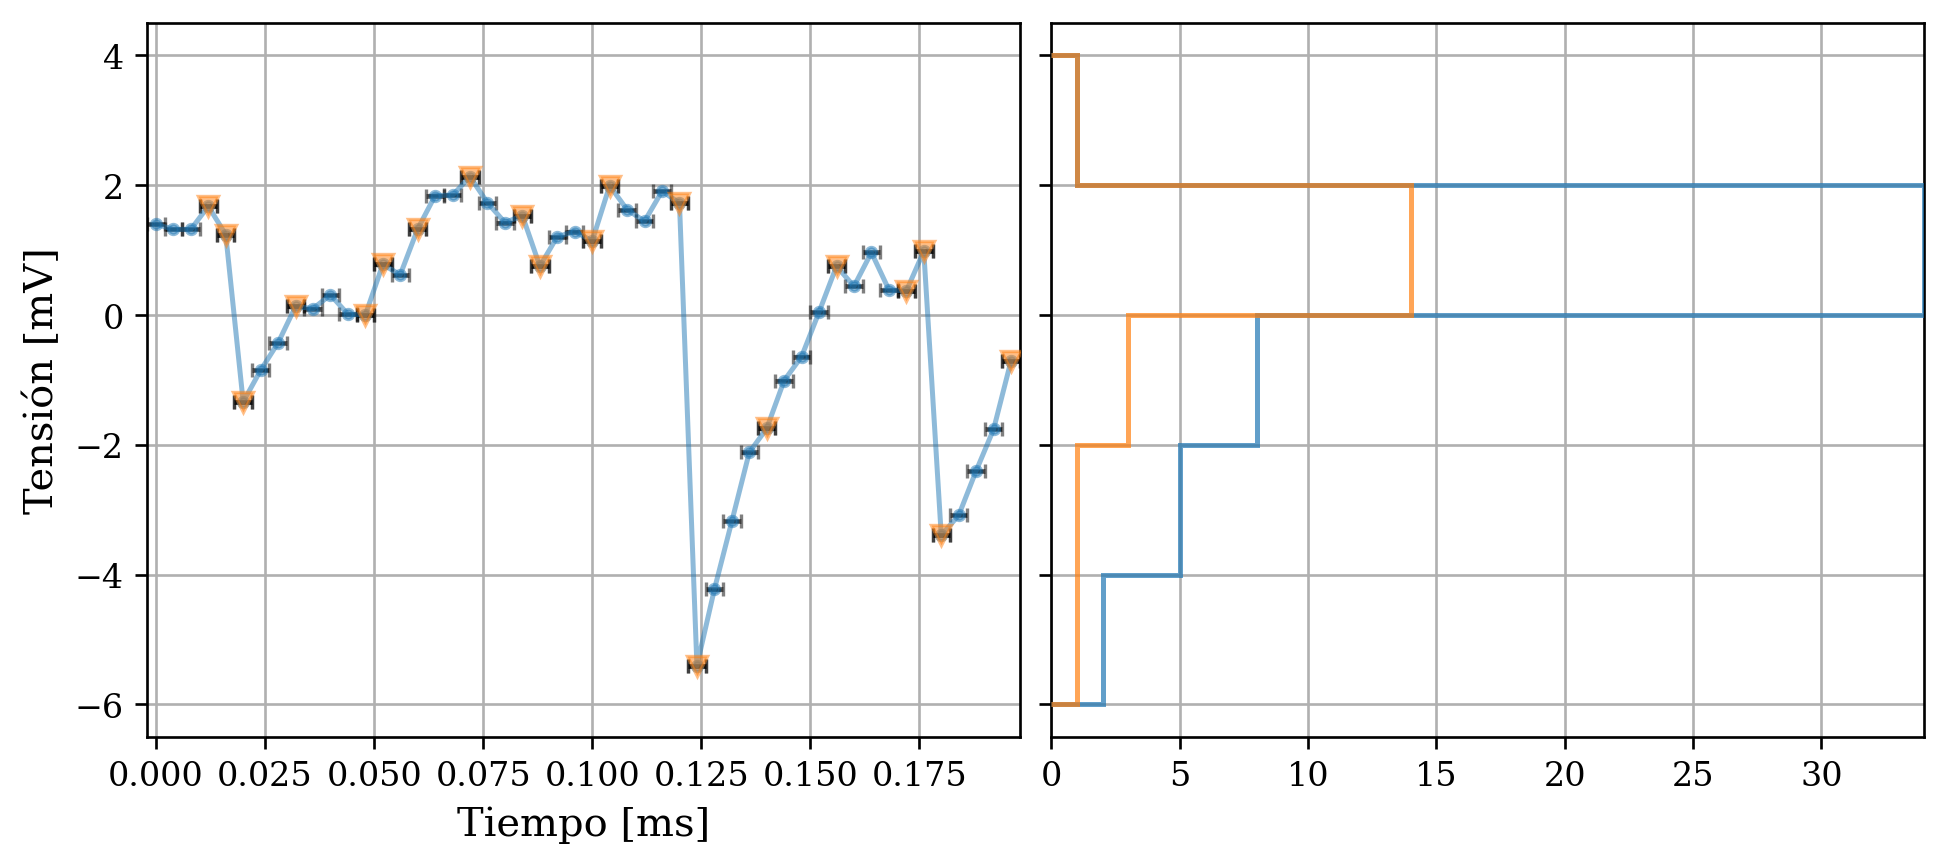

In [129]:
dt = 20  # μs
freq = 250e3  # Hz
w_size = int(dt*freq*1e-6)  # Window size in data points
n_datos = 50
med_index = 5
plot_args = tiempo, channel, min_val, max_val, med_index, n_datos
fig, axs = plot_measurements(*plot_args)
plot_custom_peaks(*plot_args, fig, window_size=w_size)
plt.show()

loaded c
ploted hist
loaded d
ploted hist


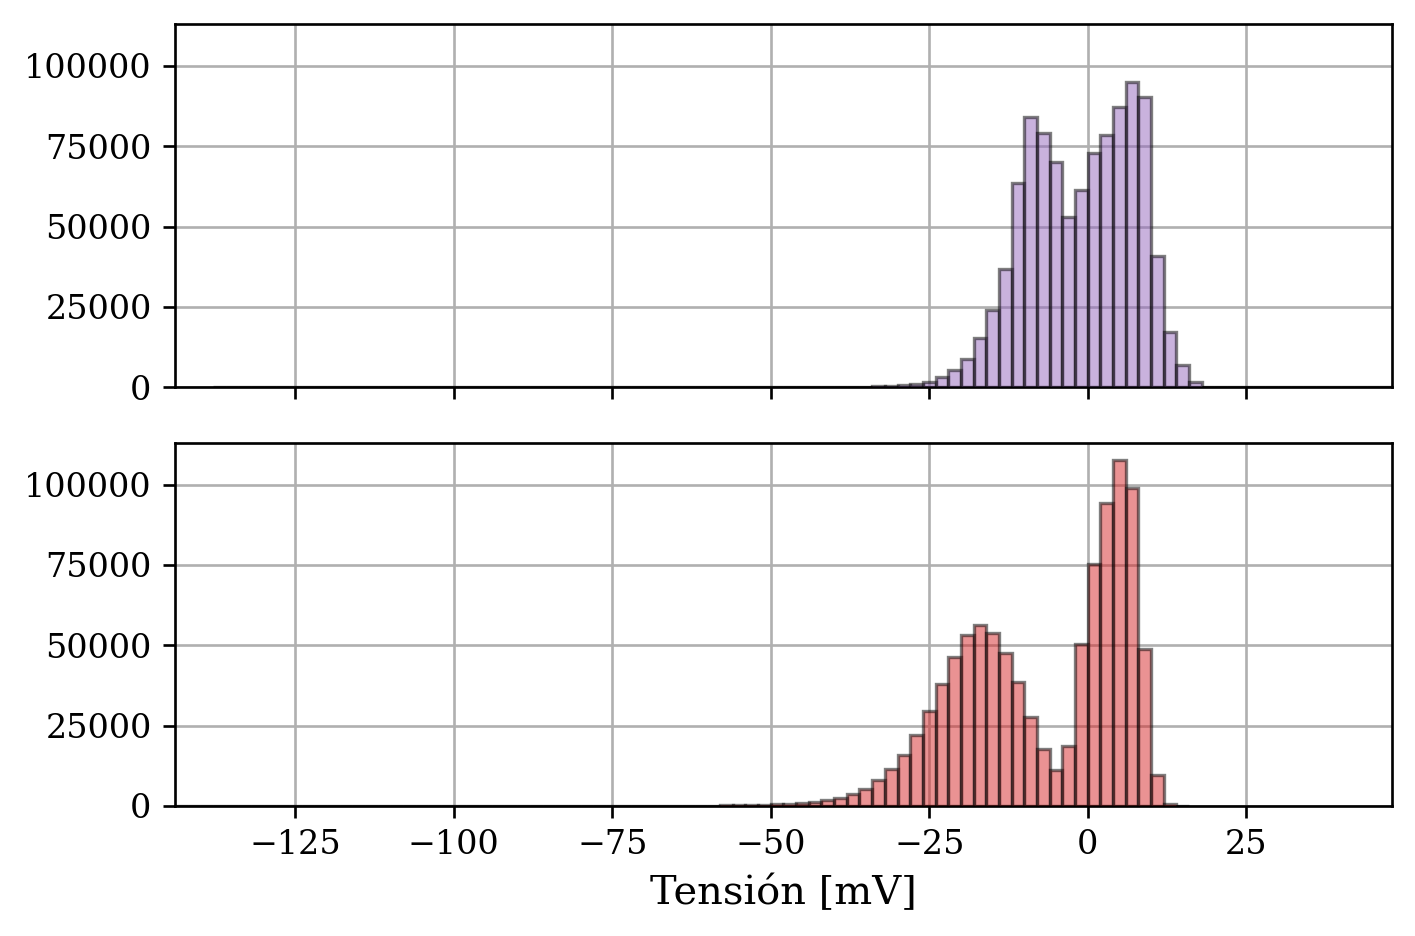

In [147]:
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
angulo = 230  # °
tension = 1050  # V
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True)
fig.subplots_adjust(hspace=0)
color_id = 4
height_dict = dict()
tension_dict = dict()
for config, ax in zip(["c", "d"], axs):
   
    tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                                + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
    print(f"loaded {config}")
    bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # V
    bins = bin_range[(volt_vals.max()*1e3 + 2 >= bin_range) & (volt_vals.min()*1e3 - 2 <= bin_range)]  # V
    dt = 100  # μs
    t, v = get_peaks(tiempo, volt_vals, int(dt*freq*1e-6))
    # v_maximos = v[v.size//2]
    obs, *_ = ax.hist(x=v*1e3, bins=bins,
                      color=f"C{color_id}", zorder=10, edgecolor="k",
                      alpha=0.5, label=config + " Sample")
    height_dict[config] = obs
    tension_dict[config] = bins[:-1] - 1
    print("ploted hist")
    color_id -= 1

    # ax.set_yscale("log")
ax.set_xlabel("Tensión [mV]")


plt.show()

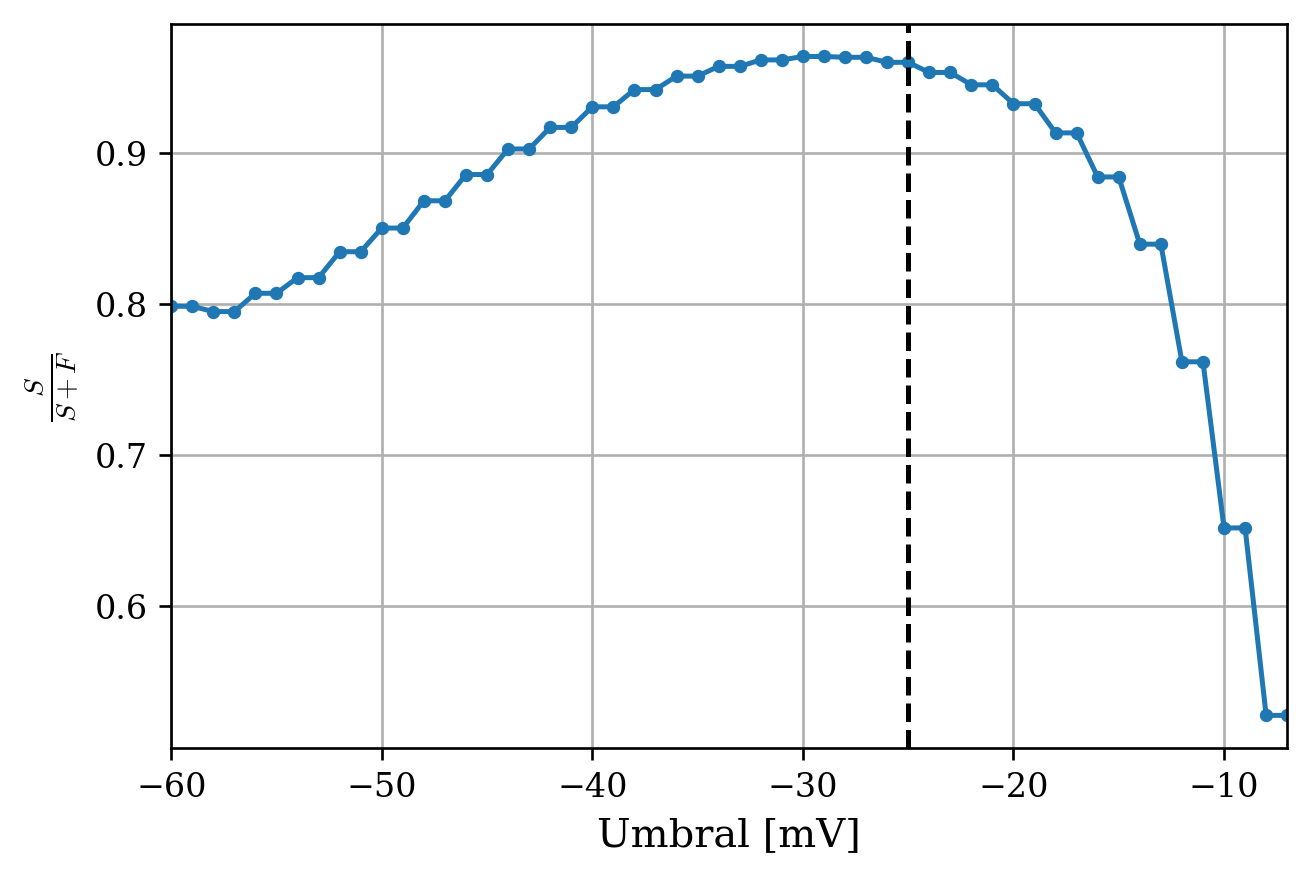

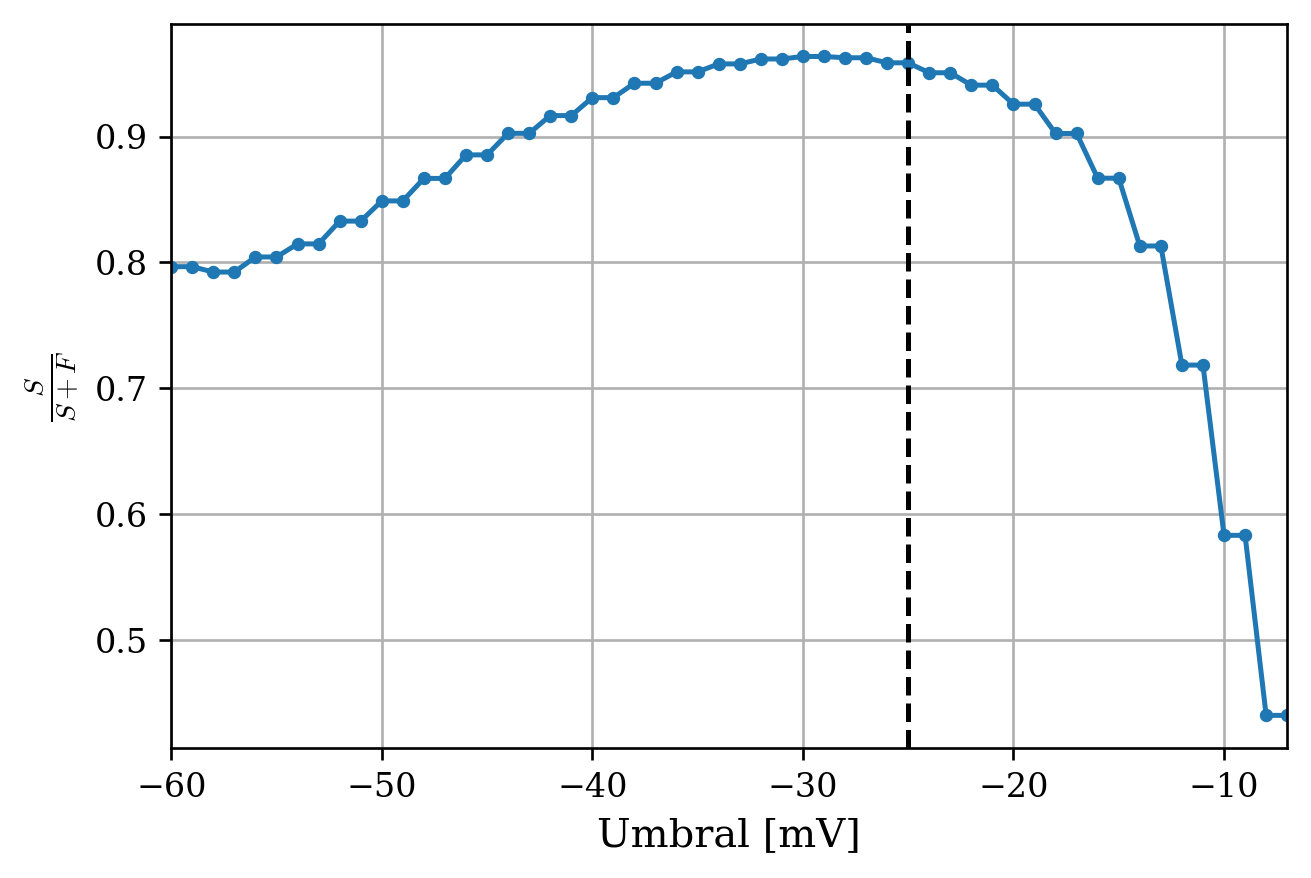

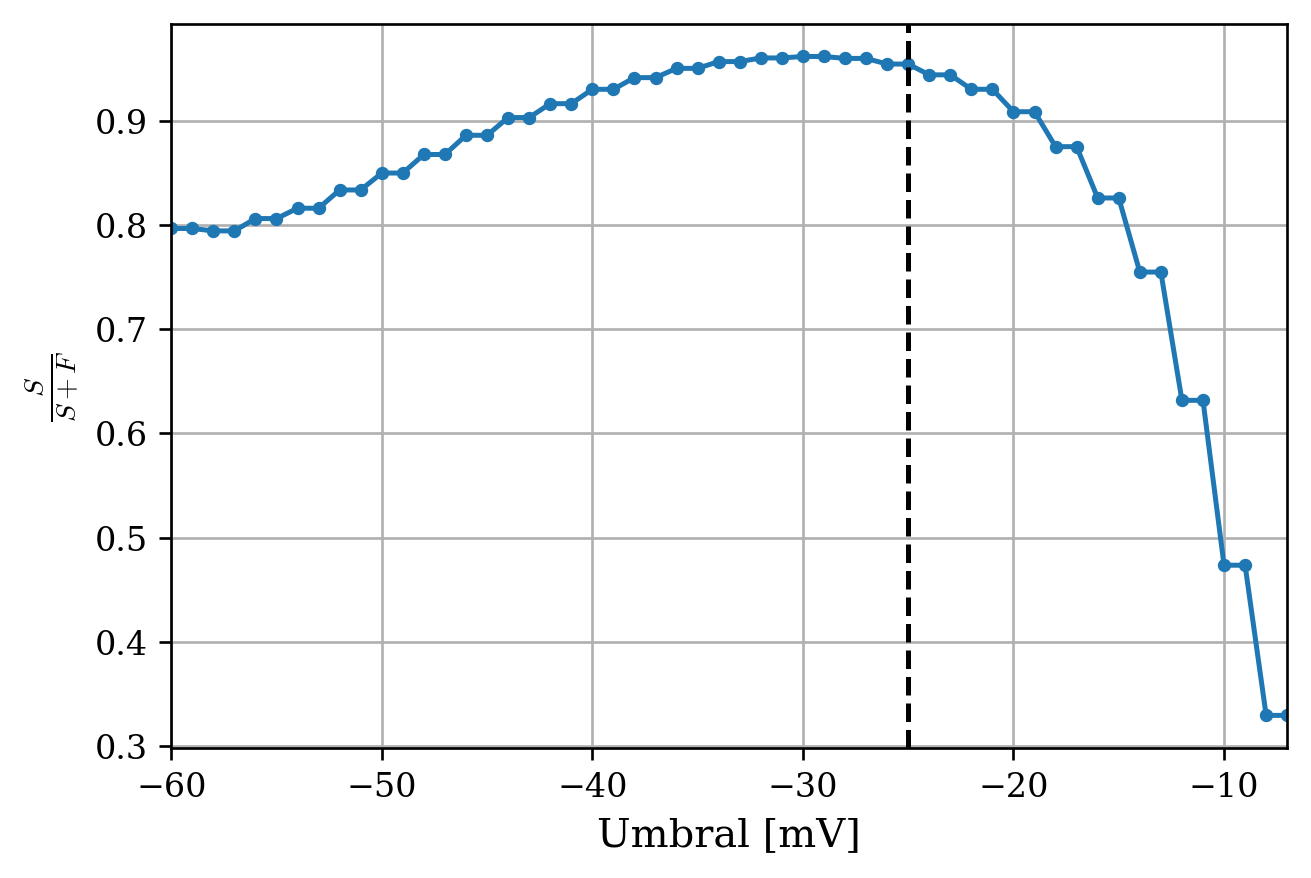

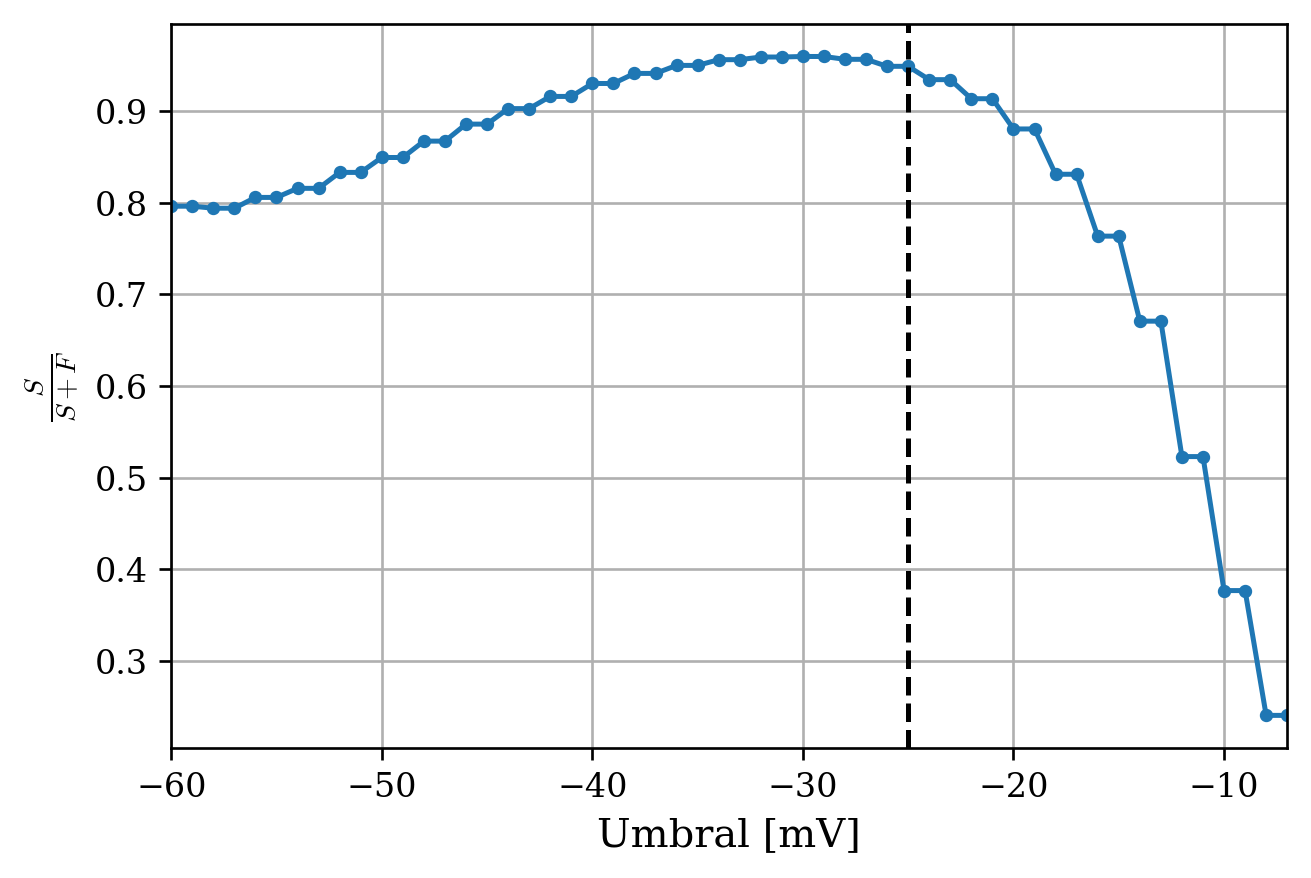

In [148]:
config_fondo = "c"
config_signal = "d"
for dt in [20, 40, 100, 200]:  # μs
    height_dict = dict()
    tension_dict = dict()
    for config, ax in zip(["c", "d"], axs):
        tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                                    + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
        bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # V
        bins = bin_range[(volt_vals.max()*1e3 + 2 >= bin_range) & (volt_vals.min()*1e3 - 2 <= bin_range)]  # V
        t, v = get_peaks(tiempo, volt_vals, int(dt*freq*1e-6))
        # v_maximos = v[v.size//2]
        obs, *_ = np.histogram(v*1e3, bins=bins,)
        height_dict[config] = obs
        tension_dict[config] = bins[:-1] - 1


    umbrales = np.arange(-60, -6, 1, dtype=float)  # mV
    frac = np.zeros_like(umbrales)
    for i, umbral in enumerate(umbrales):  # V
        signal_and_back = sum(height_dict[config_signal][tension_dict[config_signal] <  umbral])
        background = sum(height_dict[config_fondo][tension_dict[config_fondo] <  umbral])
        # print(signal_and_back, background, umbral)
        frac[i] = (signal_and_back-background)/signal_and_back

    plt.plot(umbrales, frac, '.-')
    plt.axvline(-25, ls='--', c="k")
    plt.xlabel("Umbral [mV]")
    plt.ylabel(r"$\frac{S}{S+F}$")
    plt.show()

# Poisson

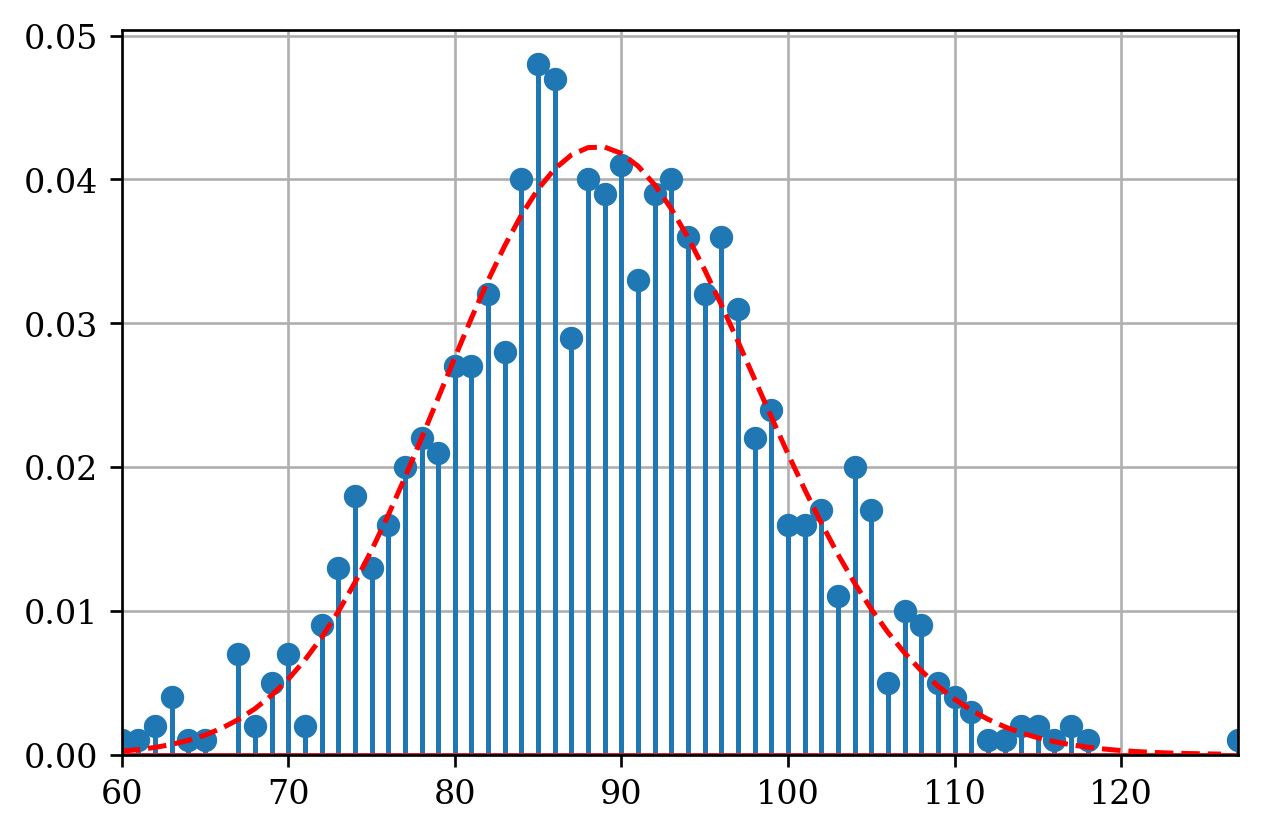

In [180]:
umbral = -25e-3  # V
dt = 100  # μs
T = 50e-3  # s
freq = 250e3  # Hz
peak_window = int(dt*freq*1e-6)
tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                            + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
t, v = get_peaks(tiempo, volt_vals, peak_window)  # s, V
t, v = t[:t.size//2], v[:v.size//2]

def count_in_period(tiempo,  # s
                    channel,  # V
                    T,  # s
                    f,  # Hz
                    umbral,  # V
                    window_size,
                    ):
    N = int(T*f/window_size)
    # print(N)
    t = np.reshape(tiempo, (-1, N))
    ch = np.reshape(channel, (-1, N))
    counts = np.sum(ch < umbral, axis=1)
    return counts

counts = count_in_period(t, v, T, freq, umbral, peak_window)
unique_vals, count_vals = np.unique(counts, return_counts=True, )

mean_count = counts.mean()
curve_vals = np.arange(unique_vals.min(), unique_vals.max(), 1)

dist_raw = poisson(mean_count)
# plt.hist(counts, bins=20,
#          color=f"C{color_id}", zorder=10, edgecolor="k",
#          alpha=0.5, label=config + " Sample")
plt.stem(unique_vals, count_vals/sum(count_vals))
plt.plot(curve_vals, dist_raw.pmf(curve_vals), '--r')
plt.ylim(bottom=0)
plt.show()